# General Description

This notebook uses R code, please make sure an R kernel is installed for your jupyter notebook or copy the code and run it in an R environment.

This notebook describes the steps for:
* reading in input flies (for both conditions)
* converting CellPhoneDB output (significant_means.txt  file) into a weight array (for both conditions)
* running Comparative analysis of COMUNET

The **input** for this notebook is 
* significant_means.txt from "cpdb_output" folder (for both conditions)
* complex_input.csv obtained from CellPhoneDB site
* gene_input.csv obtained from CellPhoneDB site

The **output** of this notebook is:
* cond1_interactions and cond2_interactions variables each containing:
    * weight_array: array of weighted adjacency matrices (#nodes x #nodes x #ligand-receptor pairs)
    * ligand_receptor_pair_df: dataframe of ligand-receptor pairs with columns:
        * “pair” contains values in a form “ligand:receptor”, i.e. ligand being at the first place, receptor being at the second place, e.g. “TNFSF13:TNFRSF17”
        * “ligand” contains ligand names, e.g. “TNFSF13”
        * “ligand_complex_composition” if ligand is a complex (e.g. “aXb2_complex”), contains genes in the ligand complex separated with a comma, e.g. “ITGAX,ITGB2”, else contains ””
        * “receptor” contains receptor names, e.g. “TNFRSF17”
        * “receptor_complex_composition” if receptor is a complex (e.g. “NKG2D_II_receptor”), contains genes in the receptor complex separated with a comma, e.g. “KLRK1,HCST”, else contains ””
    * nodes: cell types

* result variable that contains:
    * sorted_LRP_df, which is a data frame containing ligand-receptor pairs in the column “pair”, their presence notated as “shared”, if a ligand-receptor pair is present in both conditions, or “only ‘name of condition’ ”, if a ligand-receptor pair is present in only of condition, in the column “presence”, as well as the dissimilarity value in the column “dissimilarity”, the higher the dissimilarity, the more different the communication pattern for a ligand-receptor pair between the two conditions.
    * dissim_cond1_cond2, which is a matrix of all pairwise dissimilarity values for the ligand-receptor pairs between the two conditions, the rows containing ligand-receptor pairs from the condition 1, and columns containing ligand-receptor pairs from the condition 2.

# COMUNET analysis

## Libraries:

In [1]:
# libraries ####
require(COMUNET)
require(eulerr) # for euler plot in comparative analysis
# end libraries

Loading required package: COMUNET

Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 1.20.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://bioconductor.org/packages/ComplexHeatmap/

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.


Loading required package: dynamicTreeCut

Loading required package: ggplot2

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: umap

Loading required package: SDMTools

Loading required package: eulerr



## Options

In [2]:
options(stringsAsFactors = F)

## Input variables

### COMUNET input variables

These input variables will be used by COMUNET.

In [3]:
# condition names
cond1_name <- "AML328_d0"
cond2_name <- "AML328_d29"

### Paths

If you are using CellPhoneDB, please additionally download (to your working directory) gene_input.csv and complex_input.csv from the [CellPhoneDB site](https://www.cellphonedb.org/downloads).

In [4]:
main_path <- getwd() # current working directory
# input path for cond1 (AML328_d0)
cond1_input_path <- paste0(main_path
                           ,"/AML328_d0_forComparative"
                           ,"/cpdb_output") # CellPhoneDB output folder

# input path for cond2 (AML328_d29)
cond2_input_path <- paste0(main_path
                           ,"/AML328_d29_forComparative"
                           ,"/cpdb_output") # CellPhoneDB output folder

# output path
outputPath = paste0(main_path
                    ,"/comunet_output")

# Please make sure, the complex_input.csv and gene_input.csv are downloaded to your working directory
complex_input <- paste0(main_path
                        ,"/complex_input.csv"
)
gene_input <- paste0(main_path
                     ,"/gene_input.csv"
                     )

### Read in data

For the analysis, we will need to read in following data: complex_input and gene_input (since we are using CellPhoneDB), as well as normalised count matrix and annotation matrix for both conditions.

In [5]:
# complex input
complex_input <- read.csv(complex_input)
complex_input$complex_name <- gsub("_"
                                   ," "
                                   ,complex_input$complex_name)

# gene input
gene_input <- read.csv(gene_input)

### Read in CellPhoneDB output

We also need to read in the weight matrices for both conditions. In this case, our weight matrices (significant_means.txt) are produced by CellPhoneDB.

In [6]:
# Cond1 (AML328_d0)
# read in CellPhoneDB output
cond1_CellPhoneDB_output <- read.csv(paste0(cond1_input_path
                                            ,"/significant_means.txt")
                                     ,sep = "\t"
                                     ,check.names = F)

# delete duplicates
cond1_CellPhoneDB_output <- cond1_CellPhoneDB_output[!duplicated(cond1_CellPhoneDB_output$interacting_pair),]

# add row names (interacting pairs)
rownames(cond1_CellPhoneDB_output) <- cond1_CellPhoneDB_output$interacting_pair

# transform 'receptor_a' colomn into boolean
cond1_CellPhoneDB_output$receptor_a  <- sapply(cond1_CellPhoneDB_output$receptor_a
                                         ,function(i){
                                           if(i == "True") T else F
                                         }
)

# transform 'receptor_b' colomn into boolean
cond1_CellPhoneDB_output$receptor_b  <- sapply(cond1_CellPhoneDB_output$receptor_b
                                         ,function(i){
                                           if(i == "True") T else F
                                         }
)
str(cond1_CellPhoneDB_output)

# Cond2 (AML328_d29)
# read in CellPhoneDB output
cond2_CellPhoneDB_output <- read.csv(paste0(cond2_input_path
                                            ,"/significant_means.txt")
                                     ,sep = "\t"
                                     ,check.names = F)

# delete duplicates
cond2_CellPhoneDB_output <- cond2_CellPhoneDB_output[!duplicated(cond2_CellPhoneDB_output$interacting_pair),]

# add row names (interacting pairs)
rownames(cond2_CellPhoneDB_output) <- cond2_CellPhoneDB_output$interacting_pair

# transform 'receptor_a' colomn into boolean
cond2_CellPhoneDB_output$receptor_a  <- sapply(cond2_CellPhoneDB_output$receptor_a
                                         ,function(i){
                                           if(i == "True") T else F
                                         }
)

# transform 'receptor_b' colomn into boolean
cond2_CellPhoneDB_output$receptor_b  <- sapply(cond2_CellPhoneDB_output$receptor_b
                                         ,function(i){
                                           if(i == "True") T else F
                                         }
)
str(cond2_CellPhoneDB_output)

'data.frame':	319 obs. of  208 variables:
 $ id_cp_interaction  : chr  "CPI-SS04A5D6B6F" "CPI-SS0579FA162" "CPI-SS03A4F7DC8" "CPI-SS0A8627ED6" ...
 $ interacting_pair   : chr  "DLL1_NOTCH1" "IGF2_IGF1R" "AXL_GAS6" "PVR_CD226" ...
 $ partner_a          : chr  "simple:O00548" "simple:P01344" "simple:P30530" "simple:P15151" ...
 $ partner_b          : chr  "simple:P46531" "simple:P08069" "simple:Q14393" "simple:Q15762" ...
 $ gene_a             : chr  "ENSG00000275555" "ENSG00000167244" "ENSG00000167601" "ENSG00000073008" ...
 $ gene_b             : chr  "ENSG00000148400" "ENSG00000140443" "ENSG00000183087" "ENSG00000150637" ...
 $ secreted           : chr  "False" "True" "True" "True" ...
 $ receptor_a         : logi  FALSE FALSE TRUE TRUE TRUE FALSE ...
 $ receptor_b         : logi  TRUE TRUE FALSE TRUE FALSE TRUE ...
 $ annotation_strategy: chr  "curated" "curated" "guidetopharmacology.org" "curated" ...
 $ is_integrin        : chr  "False" "False" "False" "False" ...
 $ rank          

## Convert CellPhoneDB output 

In this step, we will transform the CellPhoneDB weight matrix into a COMUNET format. The CellPhoneDB weight matrix (significant_means.txt) contains ligand-receptor pairs in the rows and all pairs of cell types in the columns. COMUNET transforms it into a stack of weight matrices (i.e. weight array), one weight matrix per ligand-receptor pair. If CellPhoneDB output contains $m$ non-empty ligand-receptor pairs, then the number of matrices in the stack will be equal to $m$. Each such weight matrix has all cell types in the rows and all cell types in the columns. So if there are $n$ cell types in the data, each weight matrix is an $n \times n$ matrix. The rows of each matrix represent sending cell types, i.e. cell types that express a ligand of a ligand-receptor pair, or just partner A of an undirected interacting pair (e.g. pair of adhesion molecules). The columns of each matrix represent receiving cell types, i.e. cell types that express a receptor of a ligand-receptor pair, or partner B of an undirected interacting pair (e.g. pair of adhesion molecules). The NA values of the CellPhoneDB output are substituted with 0. 

In the language of network science, this stack of weight matrices represents a multiplex network with each matrix being one layer of the network. We regard thus each weight matrix as an adjacency matrix of a communication graph with weights representing the edges and cell types representing nodes. The higher the weight, the stronger the intensity of communication between the two cell types (nodes) that this edge connects. Each ligand-receptor pair thus gets its own communication graph in the multiplex network (i.e. one weight matrix in the weight matrix stack). For the analyses run on single-cell RNAseq, we want to underscore that one nodes represents a pool of cells, which all belong to the same cell type, and not a single cell. 

COMUNET can work with any kind of of weight matrices: expression-based weights, p-values, etc. The user can thus generate the weight matrices with any algorithm of choice and provide them to COMUNET in the format of a stack of weight matrices described above.

In case you use CellPhoneDB, we recommend to convert its output using the ```convert_CellPhoneDB_output``` function of COMUNET. The ```convert_CellPhoneDB_output``` function receives the CellPhoneDB weight matrix which we read in in the previous section, complex_input and gene_input, both of which we obtained from the [CellPhoneDB site](https://www.cellphonedb.org/downloads). The output of the ```convert_CellPhoneDB_output``` function is a list that contains:
* ```w_array``` stack of weight matrices
* ```ligand_receptor_pair_df``` data frame with columns "pair", "ligand", "ligand_complex_composition", "receptor", "receptor_complex_composition"
* ```nodes``` string vector that contains all cell types 

Note that  CellPhoneDB does not necessarily place ligand and receptors in the same order. Since COMUNET relies on the order and needs the ligand to be the first protein in the pair and the receptor the second, the ```convert_CellPhoneDB_output``` function will check the oder and swap the proteins automatically if needed. If the direction of signalling in a cell-cell communication event (e.g. integrins), the order of the interacting proteins is random.

In [7]:
# Cond1 (AML328_d0)
cond1_interactions <- convert_CellPhoneDB_output(CellPhoneDB_output = cond1_CellPhoneDB_output
                                           ,complex_input = complex_input
                                           ,gene_input = gene_input)
str(cond1_interactions)

# Cond2 (AML328_d29)
cond2_interactions <- convert_CellPhoneDB_output(CellPhoneDB_output = cond2_CellPhoneDB_output
                                           ,complex_input = complex_input
                                           ,gene_input = gene_input)
str(cond2_interactions)

List of 3
 $ weight_array           : num [1:14, 1:14, 1:99] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:14] "B" "CTL" "HSC" "HSC-like" ...
  .. ..$ : chr [1:14] "B" "CTL" "HSC" "HSC-like" ...
  .. ..$ : chr [1:99] "DLL1:NOTCH1" "IGF2:IGF1R" "GAS6:AXL" "PVR:CD226" ...
 $ ligand_receptor_pair_df:'data.frame':	99 obs. of  5 variables:
  ..$ pair                        : chr [1:99] "DLL1:NOTCH1" "IGF2:IGF1R" "GAS6:AXL" "PVR:CD226" ...
  ..$ ligand                      : chr [1:99] "DLL1" "IGF2" "GAS6" "PVR" ...
  ..$ ligand_complex_composition  : chr [1:99] "DLL1" "IGF2" "GAS6" "PVR" ...
  ..$ receptor                    : chr [1:99] "NOTCH1" "IGF1R" "AXL" "CD226" ...
  ..$ receptor_complex_composition: chr [1:99] "NOTCH1" "IGF1R" "AXL" "CD226" ...
 $ nodes                  : chr [1:14] "B" "CTL" "HSC" "HSC-like" ...
List of 3
 $ weight_array           : num [1:14, 1:14, 1:92] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:1

## Comparative analysis

We can check the overlap of ligand-receptor pairs between the two conditions.

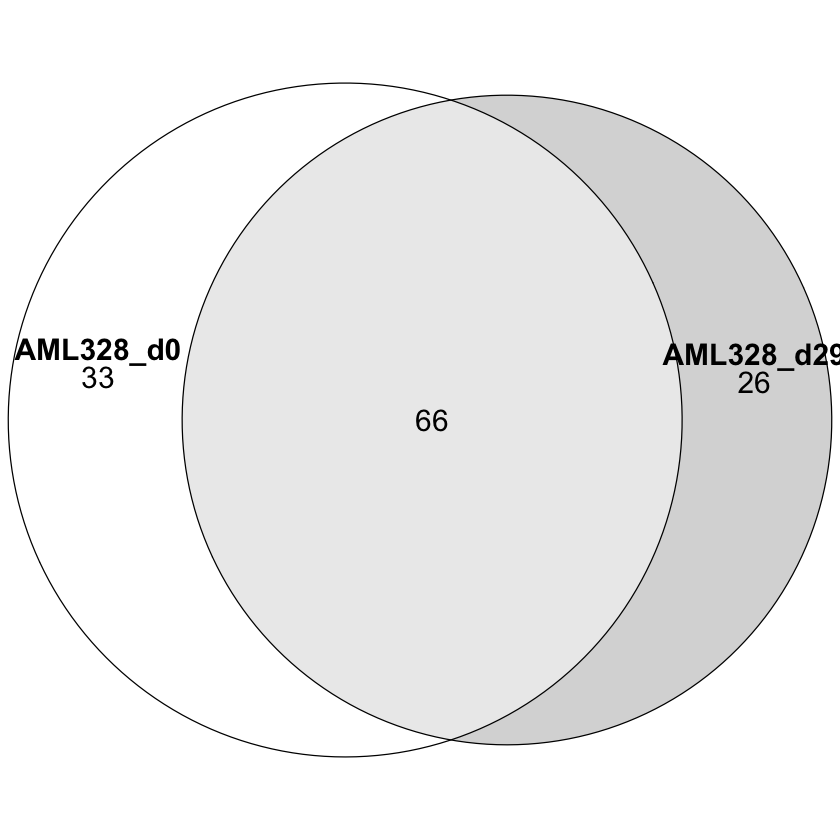

In [8]:
# plot euler
my_list <- list(cond1_interactions$ligand_receptor_pair_df$pair
                ,cond2_interactions$ligand_receptor_pair_df$pair)
names(my_list) <- c(cond1_name
                    ,cond2_name)
euler_plot <- plot(euler(my_list)
                  ,quantities = list(fontsize = 18)
                  ,counts = T
                  ,labels = list(fontsize = 18)
                 )

print(euler_plot)

We can see that 66 ligand-receptor pairs are present both at diagnosis (day 0) and in remission (day 29), 33 ligand-receptor pairs are present only at diagnosis, and 26 ligand-receptor pairs are present only in remission. Yet the fact that a ligand-receptor pair is present both at diagnosis and remission doesn't necessarily mean that it is used for communication by the same cell types. To check how similar is the usage of the shared ligand-receptor pairs at diagnosis and in remission, we will use the ```comparative_analysis``` function, which will calculate the dissimilarity value for each ligand-receptor pair.

Given two layers of a multiplex network (i.e. weight matrices for two ligand-receptor pairs) $\alpha$ and $\beta$, their dissimilarity $d^{\alpha,\beta}$ is defined as:

$d^{\alpha,\beta} = \frac{\sum\limits_{i,j=1}^N s^{\alpha,\beta}_{i,j}}{|E^\alpha \cup E^\beta|}$,

with
$
s^{\alpha,\beta}_{i,j} = 
$$
\begin{align}
%\text{Probability density function:}\\
\begin{cases}
\frac{|w^\alpha_{i,j}- w^\beta_{i,j}|}{w^\alpha_{i,j} + w^\beta_{i,j}}&\text{for $w^\alpha_{i,j}w^\beta_{i,j} \neq 0$}\\
0&\text{otherwise}\\
\end{cases}
\\
\end{align}
$$
$

where $w_{i,j}^\alpha$ is the weight of the directed edge between nodes $i$ and $j$ in the layer $\alpha$, $N$ is the total number of nodes, $E^\alpha$ is the set of edges in the layer $\alpha$, $|E^\alpha \cup E^\beta|$ is the cardinality of the union of all edges in layers $\alpha$ and $\beta$. This definition of dissimilarity can be seen as a modified version of the Jaccard similarity index (Jaccard, 1912) between the sets of edges in the two layers that takes also into account the weights and directionality of the edges. The ```comparative_analysis``` function also accepts user-defined dissimilarity measure. The user defined dissimilarity measure should take two weight arrays as arguments.

The ```comparative_analysis``` function returns a list of two objects:
* ```sorted_LRP_df```, which is a data frame containing ligand-receptor pairs in the column "pair", their presence notated as "shared", if a ligand-receptor pair is present in both conditions, or "only 'name of condition'", if a ligand-receptor pair is present in only of condition, in the column "presence", as well as the dissimilarity value in the column "dissimilarity", the higher the dissimilarity, the more different the communication pattern for a ligand-receptor pair between the two conditions.
* ```dissim_cond1_cond2```, which is a matrix of all pairwise dissimilarity values for the ligand-receptor pairs between the two conditions, the rows containing ligand-receptor pairs from the condition 1, and columns containing ligand-receptor pairs from the condition 2.

Please note that ```comparative_analysis``` expects nodes (i.e. cell types) to be the same in both conditions.

In [9]:
# run comparative analysis
result <- comparative_analysis(cond1_weight_array = cond1_interactions$weight_array
                              ,cond2_weight_array = cond2_interactions$weight_array
                              ,cond1_ligand_receptor_pair_df = cond1_interactions$ligand_receptor_pair_df
                              ,cond2_ligand_receptor_pair_df = cond2_interactions$ligand_receptor_pair_df
                              ,cond1_nodes = cond1_interactions$nodes # Please note that comparativeAnalysis expects nodes (i.e. cell types) to be the same in both conditions.
                              ,cond2_nodes = cond2_interactions$nodes # Please note that comparativeAnalysis expects nodes (i.e. cell types) to be the same in both conditions.
                              ,cond1_name = cond1_name
                              ,cond2_name = cond2_name
                              )
str(result)

List of 2
 $ sorted_LRP_df     :'data.frame':	125 obs. of  3 variables:
  ..$ pair         : chr [1:125] "CCL5:CCR5" "GP1BA:aMb2 complex" "MDK:SORL1" "IL1B:ADRB2" ...
  ..$ presence     : Ord.factor w/ 3 levels "shared"<"only AML328_d0"<..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ dissimilarity: num [1:125] 1 1 1 1 1 ...
 $ dissim_cond1_cond2: num [1:99, 1:92] 1 1 1 1 1 1 1 1 1 1 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:99] "DLL1:NOTCH1" "IGF2:IGF1R" "GAS6:AXL" "PVR:CD226" ...
  .. ..$ : chr [1:92] "TNF:FAS" "CD226:NECTIN2" "FAM3C:ADGRG5" "THBS1:a2Bb3 complex" ...


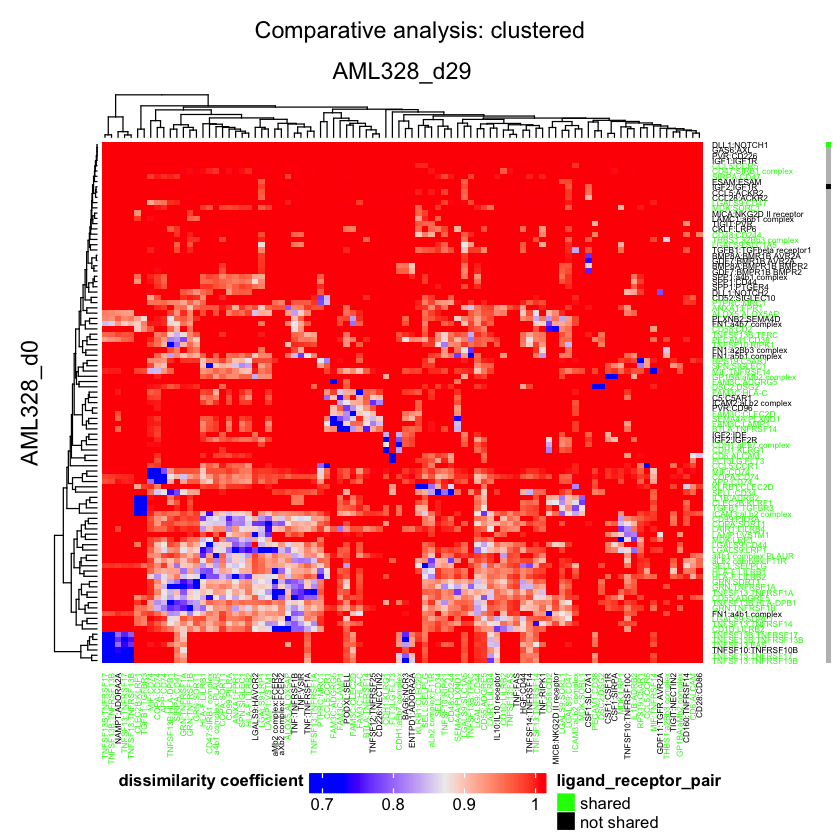

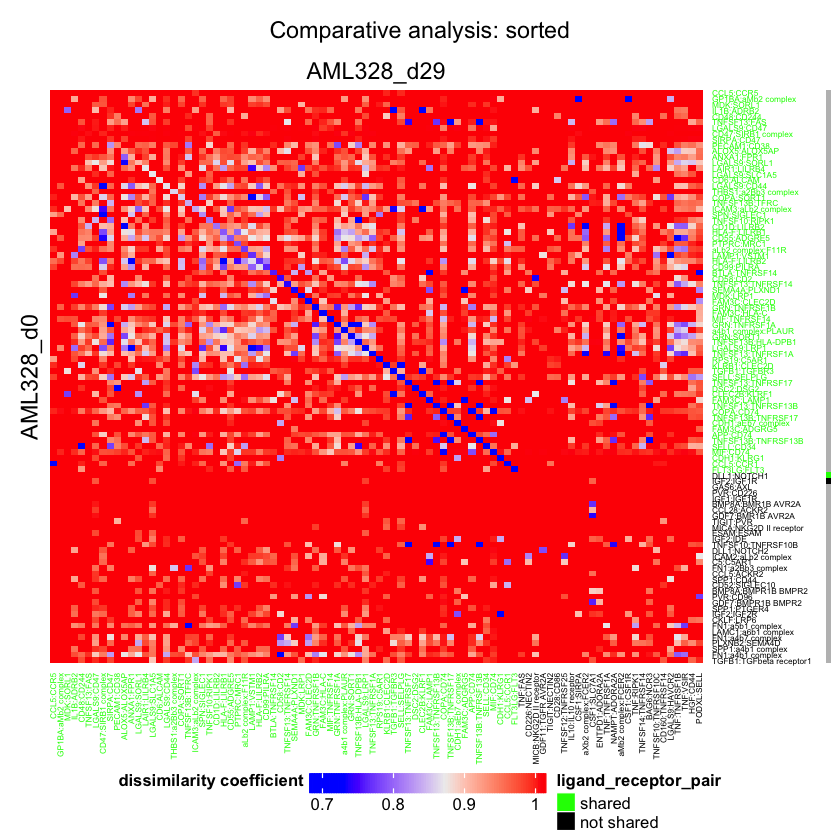

In [10]:
# plot heatmaps of dissimilatiry
plot_dissimilarity_heatmaps(dissim_cond1_cond2 = result$dissim_cond1_cond2
                            ,sorted_LRP_df = result$sorted_LRP_df
                            ,cond1_name = cond1_name
                            ,cond2_name = cond2_name
                            )

We can now take a look at how the communication graphs look like for a ligand-receptor pair, which is used in a very similar way by the cells between the two conditions, and for a ligand-receptor pair, which is used in a very different way between by the cells in the two conditions.

In each communication graph, the red colour of a node means that this node sends more signals than it receives, i.e. is a preferentially sending node. The blue colour means that a node receives more signals than it is sending, i.e. it is a preferentially receiving node. The grey colour means that either the node sends the same amount of signals, as it receives, or it is a silent node.

The thickness of an edge represents the strength of a communication signal.

In [11]:
# most similar ligand-receptor pair
similar_LRP <- result$sorted_LRP_df$pair[result$sorted_LRP_df$presence == "shared" &
                                       result$sorted_LRP_df$dissimilarity == min(result$sorted_LRP_df$dissimilarity)]
print(paste("Most similar ligand-receptor pair is"
           ,similar_LRP
           ,"with the dissimilarity value of"
           ,round(result$sorted_LRP_df$dissimilarity[result$sorted_LRP_df$pair == similar_LRP]
                 ,digits = 2)
           )
     )

# most different ligand-receptor pair
different_LRP <- result$sorted_LRP_df$pair[result$sorted_LRP_df$presence == "shared" &
                                       result$sorted_LRP_df$dissimilarity == max(result$sorted_LRP_df$dissimilarity)][1]
print(paste("Most different ligand-receptor pair is"
           ,different_LRP
           ,"with the dissimilarity value of"
           ,round(result$sorted_LRP_df$dissimilarity[result$sorted_LRP_df$pair == different_LRP]
                 ,digits = 2)
           )
     )

[1] "Most similar ligand-receptor pair is FLT3LG:FLT3 with the dissimilarity value of 0.3"
[1] "Most different ligand-receptor pair is CCL5:CCR5 with the dissimilarity value of 1"


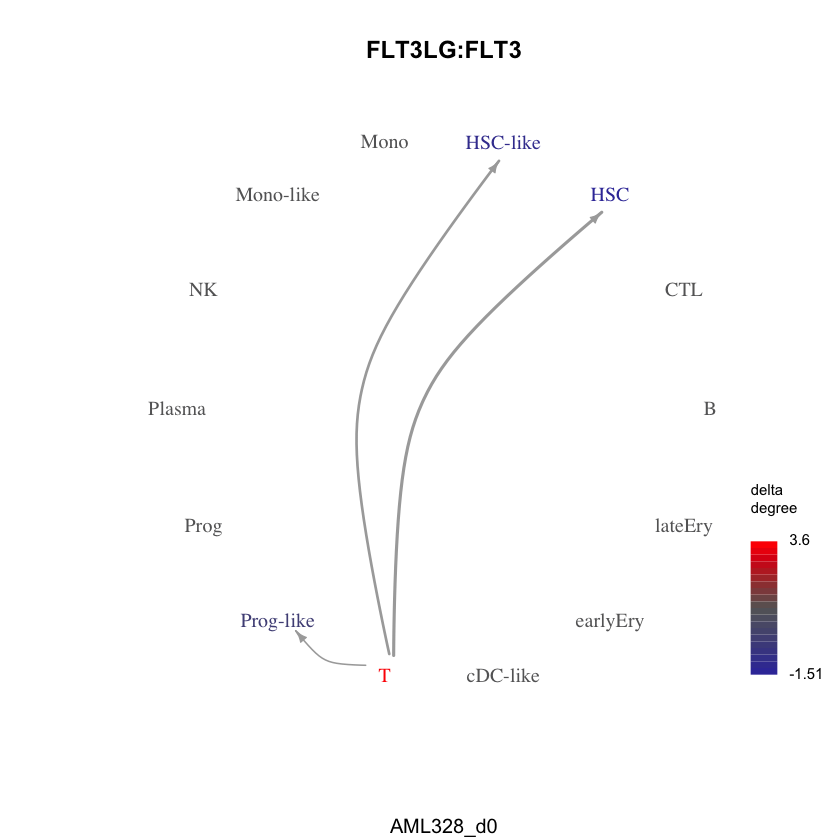

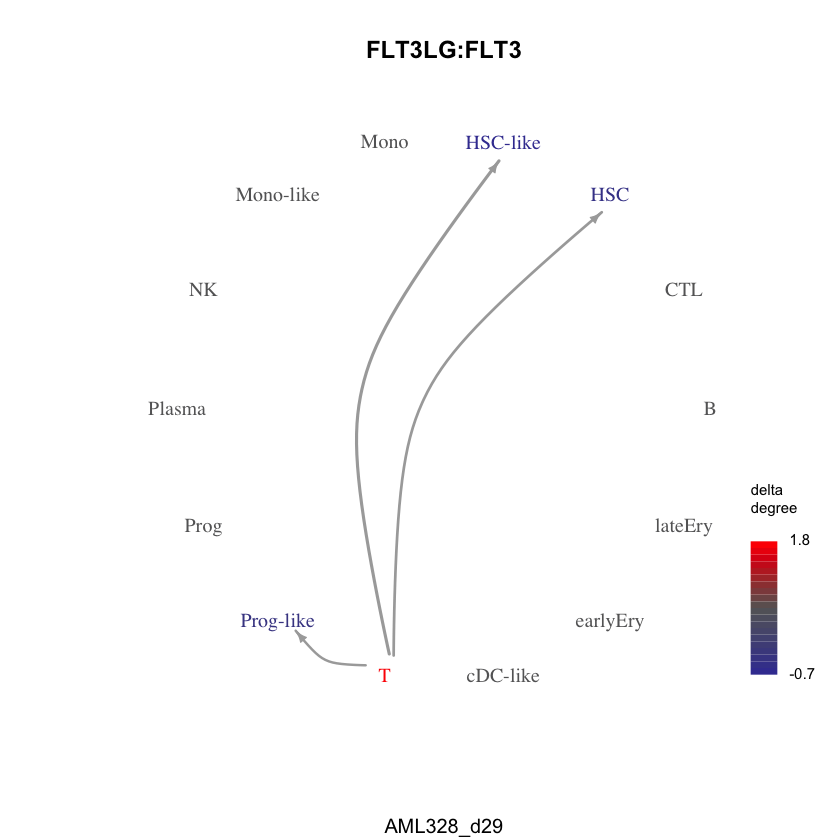

In [12]:
# plot similar LRP
# plot similar LRP for condition 1
plot_communication_graph(LRP = similar_LRP
                       ,weight_array = cond1_interactions$weight_array
                       ,ligand_receptor_pair_df = cond1_interactions$ligand_receptor_pair_df
                       ,nodes = cond1_interactions$node
                       ,title = similar_LRP
                       ,subtitle = cond1_name
                       )

# plot similar LRP for condition 2
plot_communication_graph(LRP = similar_LRP
                       ,weight_array = cond2_interactions$weight_array
                       ,ligand_receptor_pair_df = cond2_interactions$ligand_receptor_pair_df
                       ,nodes = cond2_interactions$node
                       ,title = similar_LRP
                       ,subtitle = cond2_name
)

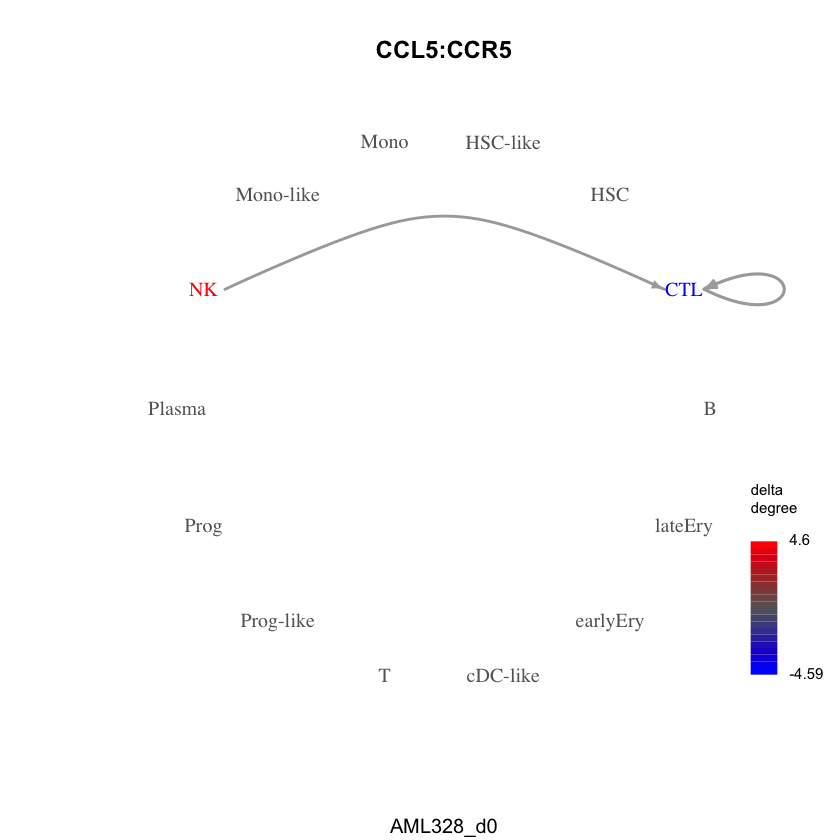

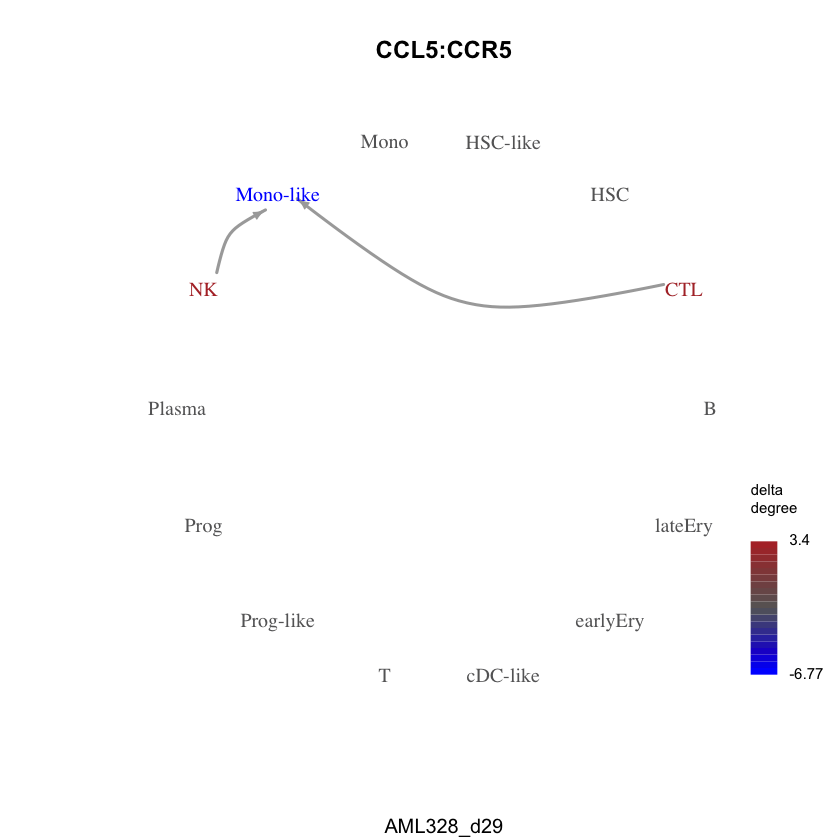

In [13]:
# plot different LRP
# plot different LRP for condition 1
plot_communication_graph(LRP = different_LRP
                       ,weight_array = cond1_interactions$weight_array
                       ,ligand_receptor_pair_df = cond1_interactions$ligand_receptor_pair_df
                       ,nodes = cond1_interactions$node
                       ,title = different_LRP
                       ,subtitle = cond1_name
)

# plot different LRP for condition 2
plot_communication_graph(LRP = different_LRP
                       ,weight_array = cond2_interactions$weight_array
                       ,ligand_receptor_pair_df = cond2_interactions$ligand_receptor_pair_df
                       ,nodes = cond2_interactions$node
                       ,title = different_LRP
                       ,subtitle = cond2_name
)

We can as well take a look at the unshared ligand-receptor pairs.

In [14]:
only_cond_1 <- result$sorted_LRP_df$pair[result$sorted_LRP_df$presence == paste("only",cond1_name) ][1]
only_cond_2 <- result$sorted_LRP_df$pair[result$sorted_LRP_df$presence == paste("only",cond2_name) ][1]
print(only_cond_1)
print(only_cond_2)

[1] "DLL1:NOTCH1"
[1] "TNF:FAS"


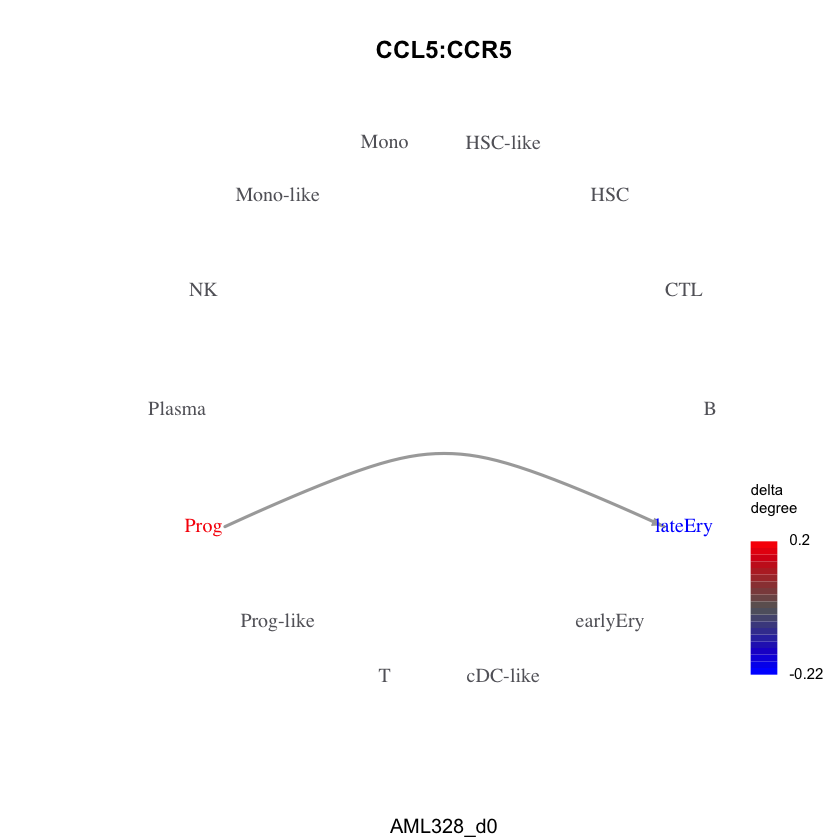

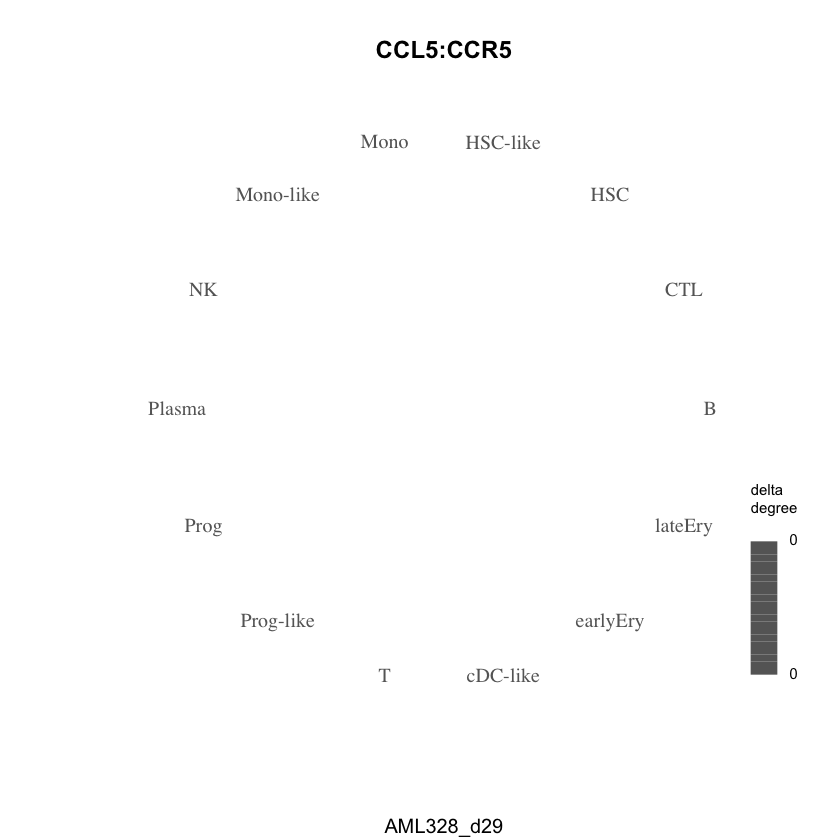

In [15]:
# plot unshared LRP from condition 1
# plot unshared LRP from condition 1 for condition 1
plot_communication_graph(LRP = only_cond_1
                       ,weight_array = cond1_interactions$weight_array
                       ,ligand_receptor_pair_df = cond1_interactions$ligand_receptor_pair_df
                       ,nodes = cond1_interactions$node
                       ,title = different_LRP
                       ,subtitle = cond1_name
)

# plot unshared LRP from condition 1 for condition 2
plot_communication_graph(LRP = only_cond_1
                       ,weight_array = cond2_interactions$weight_array
                       ,ligand_receptor_pair_df = cond2_interactions$ligand_receptor_pair_df
                       ,nodes = cond2_interactions$node
                       ,title = different_LRP
                       ,subtitle = cond2_name
)

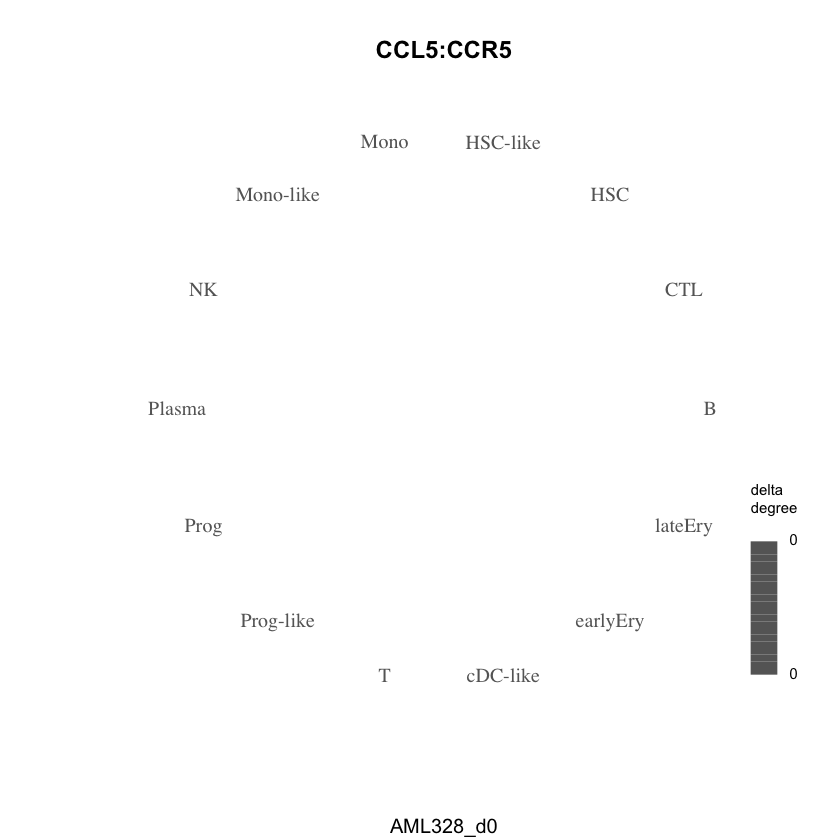

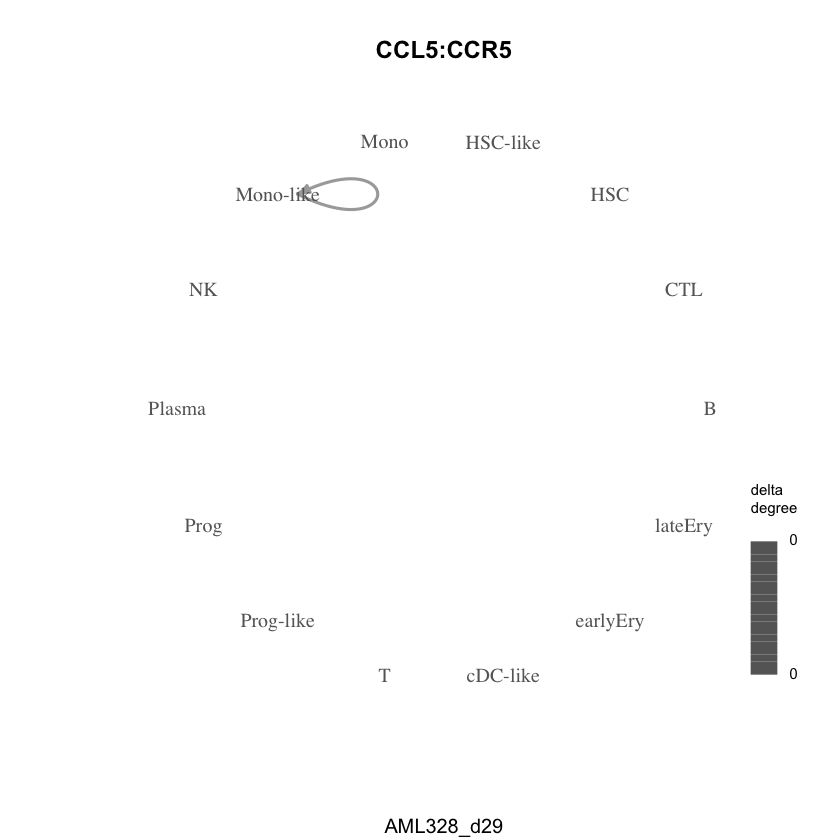

In [16]:
# plot unshared LRP from condition 2
# plot unshared LRP from condition 2 for condition 1
plot_communication_graph(LRP = only_cond_2
                       ,weight_array = cond1_interactions$weight_array
                       ,ligand_receptor_pair_df = cond1_interactions$ligand_receptor_pair_df
                       ,nodes = cond1_interactions$node
                       ,title = different_LRP
                       ,subtitle = cond1_name
)

# plot unshared LRP from condition 2 for condition 2
plot_communication_graph(LRP = only_cond_2
                       ,weight_array = cond2_interactions$weight_array
                       ,ligand_receptor_pair_df = cond2_interactions$ligand_receptor_pair_df
                       ,nodes = cond2_interactions$node
                       ,title = different_LRP
                       ,subtitle = cond2_name
)